# Introduction

In this notebook, we will implement the static **Arc-Eager** model for dependency parsing, as described in "[A Dynamic Oracle for Arc-Eager Dependency Parsing](https://aclanthology.org/C12-1059/)" by Yoav Goldberg and Joakim Nivre. Then, we will perform neural dependency parsing using the `ArcEager` model with both `Bi-LSTM` and transformers (`BERT`) as oracles.


The notebook is structured into the following sections:

*   Arc-Eager: parser and static oracle

*   Dataset: analysis and preprocessing

*   Baseline Model: Bi-LSTM

*   BERT-based Model

*   Error Analysis

*   Discussion: Overview of procedures, presentation of results, and comparison with SOTA performance in dependency parsing.

## Imports

In [1]:
!pip install datasets
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 27.1 MB/s eta 0:

In [2]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tabulate import tabulate
import torch
import torch.nn as nn
from functools import partial
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModel
from IPython.display import HTML
import spacy
from spacy import displacy
from spacy.tokens import Doc
import random

In [3]:
use_wandb = False #@param {type:"boolean"}
if use_wandb:
  import wandb
  wandb.login()

# Arc-eager

In the Arc-Eager transition system, a parser **configuration** is a triple of the form $(\sigma, \beta, A)$, where $\sigma$ represents the stack, $\beta$ denotes the buffer, and $A$ is the set of dependency arcs constructed so far.

There are four types of transitions that the parser can perform to move from one configuration to the next:
*   *`LEFT-ARC`*: Creates a head-dependent relation between the word at the front of the buffer ($b$) and the word at the top of the stack ($s$), then pops the stack. It requires the precondition that the token $s$ is not the artificial root node 0 and does not already have a head.
*   *`RIGHT-ARC`*:  Creates a head-dependent relation between the word $s$ at the top of the stack and the word $b$ at the front of the buffer, then shifts the buffer head to the stack.
*   *`REDUCE`*: Pops the stack, subject to the precondition that the top token has a head.
*   *`SHIFT`*: Removes the word at the head of the input buffer and pushes it onto the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`. Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list. Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.

We take a **terminal configuration** to be any configuration of the form $c = (\sigma, [], A)$.


References:\
https://aclanthology.org/C12-1059/ \
https://www.cs.umd.edu/class/fall2017/cmsc723/slides/slides_13.pdf

In [4]:
class ArcEager:
    def __init__(self, sentence):
        self.sentence = sentence
        self.buffer = [i for i in range(len(self.sentence))]
        self.stack = []
        self.arcs = [-1 for _ in range(len(self.sentence))]

        # One shift move to initialize the stack
        self.shift()

    # - Remove word at head of input buffer
    # - Push it on the stack
    def shift(self):
        b1 = self.buffer.pop(0)
        self.stack.append(b1)

    # - Create head-dependent rel. between word at front of buffer and word at top of stack
    # - Pop the stack
    def left_arc(self):
        s1 = self.stack.pop()
        b1 = self.buffer[0]
        self.arcs[s1] = b1

    # - Create head-dependent rel. between word on top of stack and word at front of buffer
    # - Shift buffer head to stack
    def right_arc(self):
        s1 = self.stack[-1]
        b1 = self.buffer[0]
        self.arcs[b1] = s1
        self.shift()

    # - Pop the stack
    def reduce(self):
        self.stack.pop()

    # Check whether the sentence has been processed completely
    def is_tree_final(self) -> bool:
        return len(self.buffer) == 0 and len(self.stack) == 1 # just [<ROOT>] should be left in the stack

    def print_configuration(self):
        s = [self.sentence[i] for i in self.stack]
        b = [self.sentence[i] for i in self.buffer]
        print(s, b)
        print(self.arcs)

**Oracle**

The `Oracle` class implements a `static` oracle that maps parser configurations to actions based on a gold tree. It ensures correct actions for error-free configurations and selects a single canonical action when multiple correct actions are possible.

In [5]:
class Oracle:
    def __init__(self, parser, gold_tree):
        self.parser = parser
        self.gold = gold_tree

    def is_buffer_empty(self):
        return len(self.parser.buffer) == 0

    def is_left_arc_gold(self):
        if self.is_buffer_empty():
            return False
        s1 = self.parser.stack[-1]
        b1 = self.parser.buffer[0]
        return self.gold[s1] == b1

    def is_right_arc_gold(self):
        if self.is_buffer_empty():
            return False
        s1 = self.parser.stack[-1]
        b1 = self.parser.buffer[0]
        return self.gold[b1] == s1

    def is_shift_gold(self):
        if self.is_buffer_empty(): # The buffer must not be empty
            return False
        # This dictates transition precedence of the parser
        if self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold():
            return False
        return True

    def is_reduce_gold(self):
        if len(self.parser.stack) < 2: # Just the <ROOT> is left in the stack.
            return False
        if self.is_buffer_empty():
            return True
        s1 = self.parser.stack[-1]
        b1 = self.parser.buffer[0]
        for i in self.parser.stack:
            if self.gold[s1] != -1 and (self.gold[i] == b1 or self.gold[b1] == i):
                return True
        return False

In [6]:
def plot_dependency(words, heads):
    # Load a spaCy model
    nlp = spacy.blank('en')  # Using a blank English model
    # Create a Doc object
    doc = Doc(nlp.vocab, words=words)

    # Set heads and dependency labels
    for i, token in enumerate(doc):
        head_idx = heads[i]
        if head_idx == -1:
            token.head = token  # A token is its own head if it's the root.
        else:
            token.head = doc[head_idx]
        # For simplicity, we'll set all dependency labels to 'dep' except the root, which will be 'ROOT'
        token.dep_ = 'ROOT' if head_idx == -1 else " "
    # Use displaCy to visualize the dependency
    displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})

In [7]:
example_sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold_dependencies = [-1, 2, 0, 4, 2, 4, 2 ]

arc_eager_parser = ArcEager(example_sentence)
oracle = Oracle(arc_eager_parser, gold_dependencies)

while not arc_eager_parser.is_tree_final():
  if oracle.is_left_arc_gold():
    arc_eager_parser.left_arc()
  elif oracle.is_right_arc_gold():
    arc_eager_parser.right_arc()
  elif oracle.is_reduce_gold():
    arc_eager_parser.reduce()
  elif oracle.is_shift_gold():
    arc_eager_parser.shift()

print("Final state:")
print("Buffer:", arc_eager_parser.buffer)
print("Stack:", arc_eager_parser.stack)
print("Arcs:", arc_eager_parser.arcs)

print("\nAt least one transition is satisfied: ", any([oracle.is_left_arc_gold(), oracle.is_right_arc_gold(), oracle.is_reduce_gold(), oracle.is_shift_gold()]))
print('\nParsed:', arc_eager_parser.arcs)
print('Gold:  ', gold_dependencies)

Final state:
Buffer: []
Stack: [0]
Arcs: [-1, 2, 0, 4, 2, 4, 2]

At least one transition is satisfied:  False

Parsed: [-1, 2, 0, 4, 2, 4, 2]
Gold:   [-1, 2, 0, 4, 2, 4, 2]


In [8]:
plot_dependency(example_sentence, arc_eager_parser.arcs)

# Dataset

We are going to use the _[English LinES treebank](https://universaldependencies.org/treebanks/en_lines/index.html)_ from Universal Dependencies.


## Analysis

In [9]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train", trust_remote_code=True)
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation", trust_remote_code=True)
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test", trust_remote_code=True)

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

In [10]:
print("Total:\t", len(train_dataset) + len(dev_dataset) + len(test_dataset))

print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Total:	 5243
Train:	 3176
Dev:	 1032
Test:	 1035


In [11]:
print("Dataset keys:")
print(train_dataset[0].keys())

Dataset keys:
dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])


In [12]:
upos_lists = train_dataset['upos']
flat_upos = [int(upos_element) for sublist in upos_lists for upos_element in sublist]
sorted(set(flat_upos))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

> This corpus uses 17 POS tags, each identified with a number from 0 to 17. Notably, the number 13 is missing, resulting in a total of 17 POS tags, following the UPOS scheme:
`ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X`.


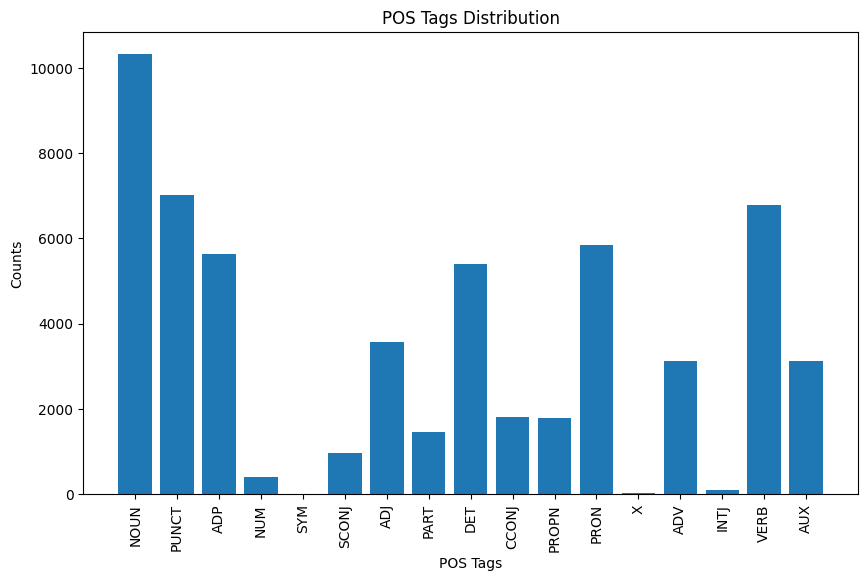

In [13]:
# POS Tags - Train

pos_counts = {}

for elem in train_dataset:
    for i, token in enumerate(elem["tokens"]):
        pos_tag = elem['upos'][i]
        if pos_tag in pos_counts:
            pos_counts[pos_tag] += 1
        else:
            pos_counts[pos_tag] = 1

sorted_pos_counts = {k: v for k, v in sorted(pos_counts.items(), key=lambda item: item[0])}
pos_ticks = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART',
             'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_pos_counts)), sorted_pos_counts.values())
plt.xlabel('POS Tags')
plt.xticks(range(len(sorted_pos_counts)), pos_ticks, rotation=90)
plt.ylabel('Counts')
plt.title('POS Tags Distribution')
plt.show()

> This plot shows the POS tags distribution, which looks standard for English sentences that come from the literature domain.

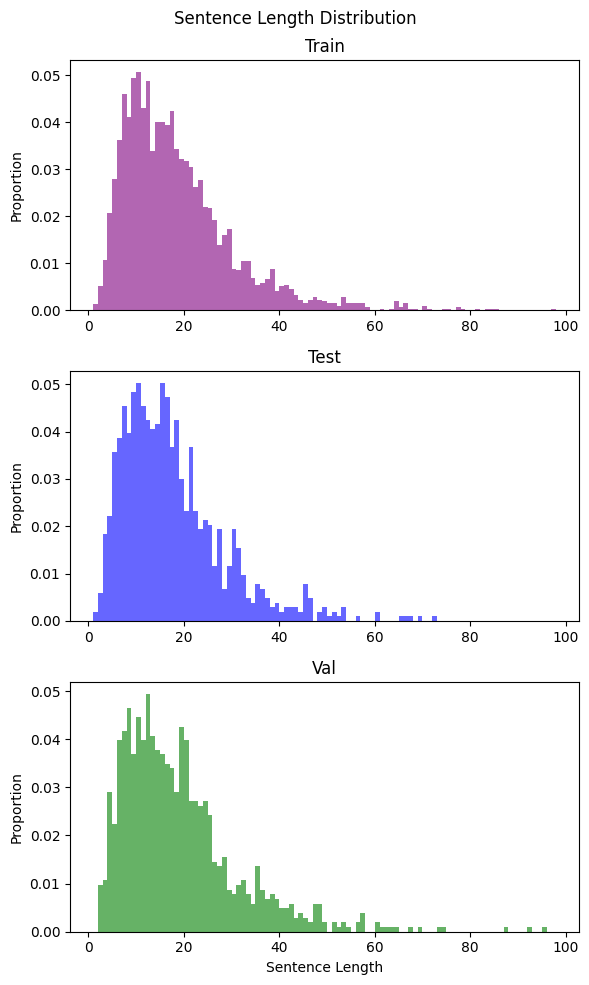

In [14]:
# Histograms

train_sentence_len = [len(sentence) for sentence in train_dataset['tokens']]
test_sentence_len = [len(sentence) for sentence in test_dataset['tokens']]
val_sentence_len = [len(sentence) for sentence in dev_dataset['tokens']]

bin_range = range(min(min(train_sentence_len), min(test_sentence_len), min(val_sentence_len)),
                  max(max(train_sentence_len), max(test_sentence_len), max(val_sentence_len)) + 1, 1)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))

# Plot histograms for each dataset
ax1.hist(train_sentence_len, bins=bin_range, alpha=0.6, color="purple", density=True, stacked=True, label='Train')
ax1.set_ylabel("Proportion")
ax1.set_title("Train")

ax2.hist(test_sentence_len, bins=bin_range, alpha=0.6, color="blue", density=True, stacked=True, label='Test')
ax2.set_ylabel("Proportion")
ax2.set_title("Test")

ax3.hist(val_sentence_len, bins=bin_range, alpha=0.6, color="green", density=True, stacked=True, label='Val')
ax3.set_xlabel("Sentence Length")
ax3.set_ylabel("Proportion")
ax3.set_title("Val")

plt.suptitle('Sentence Length Distribution')
plt.tight_layout()
plt.show()

In [19]:
# Find the peak for each dataset
train_peak_length = np.argmax(np.histogram(train_sentence_len, bins=bin_range)[0])
test_peak_length = np.argmax(np.histogram(test_sentence_len, bins=bin_range)[0])
val_peak_length = np.argmax(np.histogram(val_sentence_len, bins=bin_range)[0])

print("Most common sentence length")
print("-"*27)
print(f"Train dataset:\t {train_peak_length}")
print(f"Test dataset:\t {test_peak_length}")
print(f"Val dataset:\t {val_peak_length}")

Most common sentence length
---------------------------
Train dataset:	 9
Test dataset:	 9
Val dataset:	 11


> The histograms show us that the most common length of a sentence is 9 tokens for Train and Test and 11 for the Val dataset.

## Preprocessing

We are going to preprocess the training set by:

*   Adding `<ROOT>` token and setting head to -1.
*   Employing BERT Tokenizer in order to save in each sample its `input_ids` and `word_ids` to keep track of the token-word correspondence.
*   Removing `non-projective` trees.
*   Creating a word/index dictionary, excluding words with fewer than three occurrences.

In [ ]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])
    for j in range(0, left):
      if left < tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if left < tree[j] < right:
        return False
  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1
  map = {"<pad>": 0,
         "<ROOT>": 1,
         "<unk>": 2}  # dictionary of word/index pairs. This is our embedding list
  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1
  return map

The process_sample function is used to process our data and create the actual training samples.

The prepare_batch function is used to batch the training data.

In [ ]:
# Initialize BERT tokenizer, using the fast tokenizer implementation
fast_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased", use_fast = True)

# This funtion adds the <ROOT> token at the beginning of the samples and -1 to the head.
# We proceed with the tokenization with a BERT Tokenizer in order to save in each sample its input_ids and word_ids to keep track of the correspondence "token-word".
def add_tokenization(sample):
  sample['tokens'].insert(0, 'ROOT')
  sample['head'].insert(0, '-1')
  tokenized_sample = fast_tokenizer(sample['tokens'],
                                    is_split_into_words = True,
                                    padding='max_length',
                                    max_length=120,
                                    truncation=True,
                                    return_tensors = 'pt')
  sample['input_ids'] = tokenized_sample['input_ids'][0]
  sample['word_ids'] = tokenized_sample.word_ids()

  return sample


def process_sample(sample, get_gold_path=False, BERT=False):

  # put sentence and gold tree in our format
  sentence = sample["tokens"]
  gold = [int(i) for i in sample["head"]]  # heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary
                                       else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # Save configuration:
      # We store the configurations of the stack and the buffer.
      if len(parser.stack) == 1:
        configuration = [-1, parser.stack[-1], parser.buffer[0]]
      elif len(parser.buffer) == 0:
        configuration = [parser.stack[-2], parser.stack[-1], -1]
      else:
        configuration = [parser.stack[-2], parser.stack[-1], parser.buffer[0]]
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  if BERT:
    return enc_sentence, gold_path, gold_moves, gold, sample['input_ids'], sample['word_ids']
  else:
    return enc_sentence, gold_path, gold_moves, gold


def prepare_batch(batch_data, get_gold_path=False, BERT=False):
  data = [process_sample(s, get_gold_path=get_gold_path, BERT=BERT) for s in batch_data]
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]

  if BERT:
    input_ids = [s[4] for s in data]
    word_ids = [s[5] for s in data]
    return sentences, paths, moves, trees, input_ids, word_ids
  else:
    return sentences, paths, moves, trees

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [ ]:
train_dataset

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 3176
})

In [ ]:
train_dataset = train_dataset.map(add_tokenization)
dev_dataset = dev_dataset.map(add_tokenization)
test_dataset = test_dataset.map(add_tokenization)

# Remove non-projective sentences: heads in the gold tree are strings, we convert them to int
# then check whether the sentence is projective
train_dataset = [sample for sample in train_dataset if is_projective([int(head) for head in sample["head"]])]

# Create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples")
print("Train:\t", len(train_dataset)) # (train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

Number of samples
Train:	 2922
Dev:	 1032
Test:	 1035


In [ ]:
train_dataset[0].keys()

dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc', 'input_ids', 'word_ids'])

> The complete dataset is composed of $5,243$ sentences.\
> The train dataset is composed of $2,922$ filtered samples, after removing $254$ sentences that were non-projective.

# Baseline model: Bi-LSTM


Config parameters:

In [ ]:
LR = 1e-3 # @param ["1e-4", "5e-4", "1e-3", "5e-3"] {type:"raw"}
ACTIVATION_FN = torch.nn.Tanh() # @param ["torch.nn.LeakyReLU()", "torch.nn.Tanh()", "torch.nn.ReLU()"] {type:"raw"}

# Keep the number of epochs and batch_size fixed
EPOCHS = 15
BATCH_SIZE = 32
# Keep the architecture fixed
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2

In [ ]:
if use_wandb:
  wandb.init(project="NLP_ArcEager",
             config = {"architecture"  : "BiLSTM",
                      "learning_rate" : LR,
                      "BATCH_SIZE"    : BATCH_SIZE,
                      "epochs"        : EPOCHS,
                      "act_function"  : ACTIVATION_FN
                      }
            )

## Model definition

In this section, we introduce our baseline model, named `Net`. It employs a `2-layer Bi-LSTM` to extract embeddings from words, capturing contextual information from both past and future words in a sequence. These embeddings are then used to construct configurations $[s1, s2, b]$ which are passed to a Feedforward Neural Network. The FNN predicts the next move of the parser, incorporating a `multi-layer perceptron` to generate a 4-dimensional vector representing the probabilities of each potential transition. During inference, `the transition with the highest score is executed`, provided that the preconditions are met. In cases where preconditions are not satisfied, the model defaults to performing the second-highest scoring move (handed by the parse_step function)

In [ ]:
class Net(nn.Module):

    def __init__(self, device):
        super(Net, self).__init__()
        self.device = device
        self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

        # initialize bi-LSTM
        self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers=LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

        # initialize feedforward
        self.w1 = torch.nn.Linear(6 * LSTM_SIZE, MLP_SIZE, bias=True)
        self.activation = ACTIVATION_FN
        self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
        self.softmax = torch.nn.Softmax(dim=-1)

        self.dropout = torch.nn.Dropout(DROPOUT)

    def forward(self, x, paths):  # x is a sentence (index of the embeddings), paths is parser configuration
        # get the embeddings
        x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

        # run the bi-lstm
        h = self.lstm_pass(x)  # run embeddings through bi-lstm and get contextual embeddings as output

        # for each parser configuration that we need to score, we arrange from the
        # output of the bi-lstm the correct input for the feedforward
        mlp_input = self.get_mlp_input(paths, h)

        # run the feedforward and get the scores for each possible action
        out = self.mlp(mlp_input)

        return out

    def lstm_pass(self, x):
        x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
        h, (_, _) = self.lstm(x)
        h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(
            h)  # size h: (length_sentences, batch, output_hidden_units)
        return h

    def get_mlp_input(self, configurations, h):
        mlp_input = []
        zero_tensor = torch.zeros(2 * LSTM_SIZE, requires_grad=False).to(self.device)
        for i in range(len(configurations)):  # for every sentence in the batch
            for j in configurations[i]:  # for each configuration of a sentence
                mlp_input.append(
                    torch.cat([zero_tensor if j[0] == -1 else h[j[0]][i],
                               zero_tensor if j[1] == -1 else h[j[1]][i],
                               zero_tensor if j[2] == -1 else h[j[2]][i]]))
        mlp_input = torch.stack(mlp_input).to(self.device)
        return mlp_input

    def mlp(self, x):
        return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

    # we use this function at inference time. We run the parser and at each step
    # we pick as the next move the one with the highest score assigned by the model
    def infere(self, x):

        parsers = [ArcEager(i) for i in x]  # one parser of each sentence

        x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]  # get the embeddings

        h = self.lstm_pass(x)  # get contextual embeddings

        # inference step: the parser runs following the predictions of the model
        while not self.parsed_all(parsers):
            # get the current configuration and score next moves
            configurations = self.get_configurations(parsers)
            mlp_input = self.get_mlp_input(configurations, h)
            mlp_out = self.mlp(mlp_input)
            # take the next parsing step
            self.parse_step(parsers, mlp_out)  # constraints not implemented in the parser are hidden here

        # return the predicted dependency tree (one for each sentence in the batch)
        return [parser.arcs for parser in parsers]

    def get_configurations(self, parsers):
        configurations = []

        for parser in parsers:
            if parser.is_tree_final():
                conf = [-1, -1, -1]
            else:
                conf = [parser.stack[len(parser.stack) - 2], parser.stack[len(parser.stack) - 1]]
                if len(parser.buffer) == 0:
                    conf.append(-1)
                else:
                    conf.append(parser.buffer[0])
            configurations.append([conf])

        return configurations

    def parsed_all(self, parsers):
        for parser in parsers:
            if not parser.is_tree_final():
                return False
        return True

    # In this function, we select and perform the next move according to the scores obtained from the model.
    # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
    # is empty or a left arc if σ2 is the ROOT. For clarity's sake, we didn't implement
    # these checks in the parser, so we must do them here. This renders the function quite ugly
    def parse_step(self, parsers, moves):
        moves_argm = moves.argmax(-1)

        for i in range(len(parsers)):
            if parsers[i].is_tree_final():
                continue
            else:
                move_scores_sorted = np.argsort(-moves[i].cpu().numpy())
                s1 = parsers[i].stack[-1]
                is_only_root_on_stack = bool(s1 == 0)
                is_head_assigned = bool(parsers[i].arcs[s1] != -1)
                is_buffer_empty = bool(len(parsers[i].buffer) == 0)

                # 0 is Left arc
                if moves_argm[i] == 0:
                    if not is_buffer_empty and not is_only_root_on_stack and not is_head_assigned:
                        parsers[i].left_arc()
                    else:
                        if is_buffer_empty:
                            parsers[i].reduce()
                        else: # buffer not empty
                            if move_scores_sorted[1] == 1: # 1 is Right arc
                                parsers[i].right_arc()
                            elif move_scores_sorted[1] == 2 and not is_only_root_on_stack: # 2 is Reduce
                                parsers[i].reduce()
                            else:
                                parsers[i].shift()
                # 1 is Right arc
                elif moves_argm[i] == 1:
                    if not is_buffer_empty:
                        parsers[i].right_arc()
                    else: # buffer is empty (we can't do shift)
                        parsers[i].reduce()

                # 2 is Reduce
                elif moves_argm[i] == 2:
                    if is_head_assigned and not is_only_root_on_stack:
                        parsers[i].reduce()
                    else:
                        if not is_head_assigned and not is_buffer_empty:
                            if move_scores_sorted[1] == 0 and not is_only_root_on_stack: # 0 is Left arc
                                parsers[i].left_arc()
                            elif move_scores_sorted[1] == 1: # 1 is Right arc
                                parsers[i].right_arc()
                            else:
                                parsers[i].shift()
                        else: # buffer is empty or head is assigned
                            if is_buffer_empty:
                                parsers[i].reduce()
                            else: # head is assigned
                                if move_scores_sorted[1] == 1:
                                    parsers[i].right_arc()
                                else:
                                    parsers[i].shift()
                # 3 is Shift
                elif moves_argm[i] == 3:
                    if not is_buffer_empty:
                        parsers[i].shift()
                    else:
                        parsers[i].reduce()

## Train and test

Now that we have defined all our components, we are ready to train our model.

Here we first define our evaluation function. We use `UAS (Unlabeled Accuracy Score)` which is the percentage of correct arcs predicted over all the arcs.

Also, we define our train loop and the test function to run inference.

In [ ]:
def evaluate(gold, preds): # returns % of correct dependency edges
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) # sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count += 1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

Let's create dataloaders for train, development and test sets.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = Net(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  if use_wandb:
    wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch+1, avg_train_loss, val_uas))

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   1 | avg_train_loss: 1.058 | dev_uas: 0.543 |
Epoch:   2 | avg_train_loss: 0.920 | dev_uas: 0.637 |
Epoch:   3 | avg_train_loss: 0.884 | dev_uas: 0.658 |
Epoch:   4 | avg_train_loss: 0.866 | dev_uas: 0.678 |
Epoch:   5 | avg_train_loss: 0.855 | dev_uas: 0.682 |
Epoch:   6 | avg_train_loss: 0.845 | dev_uas: 0.697 |
Epoch:   7 | avg_train_loss: 0.837 | dev_uas: 0.709 |
Epoch:   8 | avg_train_loss: 0.831 | dev_uas: 0.701 |
Epoch:   9 | avg_train_loss: 0.826 | dev_uas: 0.714 |
Epoch:  10 | avg_train_loss: 0.819 | dev_uas: 0.701 |
Epoch:  11 | avg_train_loss: 0.816 | dev_uas: 0.720 |
Epoch:  12 | avg_train_loss: 0.812 | dev_uas: 0.729 |
Epoch:  13 | avg_train_loss: 0.808 | dev_uas: 0.722 |
Epoch:  14 | avg_train_loss: 0.806 | dev_uas: 0.731 |
Epoch:  15 | avg_train_loss: 0.804 | dev_uas: 0.726 |


In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

if use_wandb:
  wandb.log({"test_uas": test_uas})
  wandb.finish()

test_uas: 0.732


# BERT-based model

In [ ]:
model_name = "bert-base-multilingual-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

BERT_model = AutoModel.from_pretrained(model_name).to(device)
print(BERT_model)

Device: cpu


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(105879, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
sample_sentence = train_dataset[0]

print('Original text:\t', sample_sentence['tokens'])

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)
encoded_input = tokenizer(sample_sentence['tokens'],
                          is_split_into_words = True, padding='max_length',
                          max_length=120, truncation=True, return_tensors = 'pt')
encoded_input = encoded_input.to(device)
output = BERT_model(**encoded_input)

print('Tokenized text:\t', tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])[:25])
print('\nTokenized input ids:\t', encoded_input['input_ids'][0,:25])
print('\nBert model embeddings shape:', output.last_hidden_state.shape)

Original text:	 ['ROOT', 'Show', 'All']
Tokenized text:	 ['[CLS]', 'root', 'show', 'all', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Tokenized input ids:	 tensor([  101, 33765, 11391, 10367,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])

Bert model embeddings shape: torch.Size([1, 120, 768])


In [ ]:
# Parameters
EMB_SIZE = 768
MLP_SIZE = 200
DROPOUT = 0.2

EPOCHS = 15 # @param {type:"slider", min:1, max:30, step:1}
LR = 1e-3 # @param ["1e-3", "5e-3", "1e-4", "5e-4"] {type:"raw"}
BATCH_SIZE = 32 # @param {type:"slider", min:8, max:64, step:8}
ACTIVATION_FN= torch.nn.ReLU() # @param ["torch.nn.ReLU()", "torch.nn.LeakyReLU()","torch.nn.Tanh()"] {type:"raw"}

## Model definition

We are going to use the Multilingual BERT (`'bert-base-multilingual-uncased'`) text encoder to generate contextualized embeddings for the input words. This [model](https://huggingface.co/bert-base-multilingual-uncased) is pretrained on the top 102 languages with the largest Wikipedia using a masked language modeling (MLM) objective. Also, it is uncased: it does not make a difference between english and English.

The `BERTNet` model focuses on extracting information from the last 4 hidden layers of BERT to capture more local contextual details.

The input sentences are tokenized using a FastTokenizer, resulting in `'input_ids'` and `'word_ids'` for each sample. FastTokenizer is employed to handle BPE tokenization, and the `'word_ids'` help track subtokens, allowing the model to average embeddings corresponding to a specific word.

For input sentences, BERT requires `'input_ids'` to generate word embeddings. After processing subtokens, the implementation follows the same structure as the Bi-LSTM model.

In [ ]:
class BERTNet(nn.Module):

  def __init__(self, device):
    super(BERTNet, self).__init__()


    # initialize feedforward
    self.w1 = torch.nn.Linear(3*EMB_SIZE, MLP_SIZE, bias=True)
    self.activation = ACTIVATION_FN
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, input_ids, paths, word_ids):
    # run BERT encoder
    h = self.bert_pass(input_ids)
    # for each parser configuration that we need to score we arrange from the
    # output of BERT encoder the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h, word_ids).to(device)
    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input).to(device)

    return out

  def bert_pass(self, input_ids): # Extracts embeddings using BERT
    input_ids = torch.tensor(input_ids).to(device) # inputs to device
    h = BERT_model(input_ids.to(device), output_hidden_states = True) # Returns (batch, len_sent, hid) for each layer
    h = torch.stack(h.hidden_states[-4:]).sum(0).to(device)
    return h # shape = (batch, len_sent, hid)

  def get_mlp_input(self, configurations, h, word_ids): # Creates the inputs for the feedforward
    mlp_input = []
    zero_tensor = torch.zeros(EMB_SIZE, requires_grad=False).to(device)

    for i in range(len(configurations)): # for every sentence in the batch
      word_ids_i = np.array(word_ids[i]) # word_ids of the i-th sentence

      for j in configurations[i]: # for each configuration of a sentence
        j0_tokens = np.where(word_ids_i == j[0])[0]
        j1_tokens = np.where(word_ids_i == j[1])[0]
        j2_tokens = np.where(word_ids_i == j[2])[0]

        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else torch.mean(h[i][j0_tokens], dim=0),
                                    zero_tensor if j[1]==-1 else torch.mean(h[i][j1_tokens], dim=0),
                                    zero_tensor if j[2]==-1 else torch.mean(h[i][j2_tokens], dim=0)]))
    mlp_input = torch.stack(mlp_input).to(device)

    return mlp_input

  def mlp(self, x): # pass the input to the feedforward
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, sentences, input_ids, word_ids):

    parsers = [ArcEager(i) for i in sentences]

    h = self.bert_pass(input_ids)
    pred_moves = [[] for _ in range(len(parsers))] # to store the moves

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)

      mlp_input = self.get_mlp_input(configurations, h, word_ids).to(device)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      pred_moves = self.parse_step(parsers, mlp_out, pred_moves)

    # return the predicted dependency tree + predicted moves
    return [parser.arcs for parser in parsers], pred_moves

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      elif len(parser.stack) == 1:
        conf = [-1, parser.stack[-1], parser.buffer[0]]
      else:
        conf = [parser.stack[-2], parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function, we select and perform the next move according to the scores obtained from the model.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT.
  def parse_step(self, parsers, moves, pred_moves):
    moves_argm = moves.argmax(-1)

    for i in range(len(parsers)):
        if parsers[i].is_tree_final():
            continue
        else:
            move_scores_sorted = np.argsort(-moves[i].cpu().numpy())
            s1 = parsers[i].stack[-1]
            is_only_root_on_stack = bool(s1 == 0)
            is_head_assigned = bool(parsers[i].arcs[s1] != -1)
            is_buffer_empty = bool(len(parsers[i].buffer) == 0)

            # 0 is Left arc
            if moves_argm[i] == 0:
                if not is_buffer_empty and not is_only_root_on_stack and not is_head_assigned:
                    parsers[i].left_arc()
                    pred_moves[i].append(0)

                else:
                    if is_buffer_empty:
                        parsers[i].reduce()
                        pred_moves[i].append(2)

                    else: # buffer not empty
                        if move_scores_sorted[1] == 1: # 1 is Right arc
                            parsers[i].right_arc()
                            pred_moves[i].append(1)
                        elif move_scores_sorted[1] == 2 and not is_only_root_on_stack: # 2 is Reduce
                            parsers[i].reduce()
                            pred_moves[i].append(2)

                        else:
                            parsers[i].shift()
                            pred_moves[i].append(3)

            # 1 is Right arc
            elif moves_argm[i] == 1:
                if not is_buffer_empty:
                    parsers[i].right_arc()
                    pred_moves[i].append(1)

                else: # buffer is empty (we can't do shift)
                    parsers[i].reduce()
                    pred_moves[i].append(2)


            # 2 is Reduce
            elif moves_argm[i] == 2:
                if is_head_assigned and not is_only_root_on_stack:
                    parsers[i].reduce()
                    pred_moves[i].append(2)

                else:
                    if not is_head_assigned and not is_buffer_empty:
                        if move_scores_sorted[1] == 0 and not is_only_root_on_stack: # 0 is Left arc
                            parsers[i].left_arc()
                            pred_moves[i].append(0)

                        elif move_scores_sorted[1] == 1: # 1 is Right arc
                            parsers[i].right_arc()
                            pred_moves[i].append(1)

                        else:
                            parsers[i].shift()
                            pred_moves[i].append(3)
                    else: # buffer is empty or head is assigned
                        if is_buffer_empty:
                            parsers[i].reduce()
                            pred_moves[i].append(2)

                        else: # head is assigned
                            if move_scores_sorted[1] == 1:
                                parsers[i].right_arc()
                                pred_moves[i].append(1)

                            else:
                                parsers[i].shift()
                                pred_moves[i].append(3)

            # 3 is Shift
            elif moves_argm[i] == 3:
                if not is_buffer_empty:
                    parsers[i].shift()
                    pred_moves[i].append(3)

                else:
                    parsers[i].reduce()
                    pred_moves[i].append(2)

    return pred_moves


## Train and Test

Now that we have defined all our components, we are ready to train and test our model.

Here we first define our evaluation function, for which we again use `UAS (Unlabeled Accuracy Score)` which is the percentage of correct arcs predicted over all the arcs.

Also, we define our train loop and the test function to run inference.

In [ ]:
def evaluate_BERT(gold, preds):
  total = 0
  correct = 0
  wrong_non_proj = 0 # we want to count how many non-projective tree we have parsed wrongly
  non_proj = 0       # we want to count how many non-projective tree there are
  wrong_ind = []

  for n, g, p in zip((range(len(gold))), gold, preds):

    found_non_proj = False
    found_wrong = False
    already_checked = False

    if not is_projective(g):
      found_non_proj = True
      non_proj += 1

    for i in range(1, len(g)):
      total += 1

      if g[i] == p[i]:
        correct += 1

      else:
        if not already_checked:
          found_wrong = True
          wrong_ind.append(n)

          if found_non_proj:
              wrong_non_proj += 1

          already_checked = True

  return correct/total, wrong_non_proj, non_proj, wrong_ind

def train_BERT(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:

    optimizer.zero_grad()
    sentences, paths, moves, trees, input_ids, word_ids = batch

    out = model(input_ids, paths, word_ids)
    labels = torch.tensor(sum(moves, [])).to(device) # sum(moves, []) flattens the array
    loss = criterion(out, labels)

    count += 1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss / count

def test_BERT(model, dataloader):
  model.eval()

  gold = []
  preds = []
  pred_moves_BERT = [[] for _ in range(len(dataloader))]

  for i, batch in enumerate(dataloader):

    sentences, paths, moves, trees, input_ids, word_ids = batch

    with torch.no_grad():
      pred, pred_moves = model.infere(sentences, input_ids, word_ids)

      pred_moves_BERT[i] = pred_moves
      gold += trees
      preds += pred

  return evaluate_BERT(gold, preds), pred_moves_BERT, preds

In [ ]:
train_dataloader_BERT = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True, BERT=True))
dev_dataloader_BERT = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, BERT=True))
test_dataloader_BERT = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, BERT=True))

In [ ]:
if use_wandb:
  wandb.init(project="NLP_ArcEager",
             config={"architecture"  : "BERT",
                     "learning_rate" : LR,
                     "batch_size"    : BATCH_SIZE,
                     "epochs"        : EPOCHS,
                     "act_function"  : ACTIVATION_FN})

In [ ]:
print("Training on device:", device)

model = BERTNet(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):

  avg_train_loss = train_BERT(model, train_dataloader_BERT, criterion, optimizer)
  (val_uas, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT, _ = test_BERT(model, dev_dataloader_BERT)

  torch.cuda.empty_cache()
  _ = gc.collect()

  if use_wandb:
    wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch+1, avg_train_loss, val_uas))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Training on device: cuda
Epoch:   1 | avg_train_loss: 1.053 | dev_uas: 0.647 |
Epoch:   2 | avg_train_loss: 0.874 | dev_uas: 0.749 |
Epoch:   3 | avg_train_loss: 0.847 | dev_uas: 0.773 |
Epoch:   4 | avg_train_loss: 0.838 | dev_uas: 0.795 |
Epoch:   5 | avg_train_loss: 0.829 | dev_uas: 0.807 |
Epoch:   6 | avg_train_loss: 0.825 | dev_uas: 0.809 |
Epoch:   7 | avg_train_loss: 0.821 | dev_uas: 0.816 |
Epoch:   8 | avg_train_loss: 0.816 | dev_uas: 0.813 |
Epoch:   9 | avg_train_loss: 0.810 | dev_uas: 0.829 |
Epoch:  10 | avg_train_loss: 0.809 | dev_uas: 0.831 |
Epoch:  11 | avg_train_loss: 0.806 | dev_uas: 0.830 |
Epoch:  12 | avg_train_loss: 0.803 | dev_uas: 0.830 |
Epoch:  13 | avg_train_loss: 0.802 | dev_uas: 0.837 |
Epoch:  14 | avg_train_loss: 0.800 | dev_uas: 0.836 |
Epoch:  15 | avg_train_loss: 0.799 | dev_uas: 0.840 |


In [ ]:
(test_uas, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT, pred_configs_BERT = test_BERT(model, test_dataloader_BERT)

print("test_uas: {:5.3f}".format( test_uas))

if use_wandb:
  wandb.log({"test_uas": test_uas})

test_uas: 0.846


In [ ]:
if use_wandb:
  wandb.finish()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#save_path = '/content/drive/bert_based_model.pth'
# Google Drive is not available with the UniPd account, so let's save to local storage:
save_path = '/content/bert_based_model.pth'
# Note: Make sure to download the model from session storage afterwards.

# Save model state dict
torch.save(model.state_dict(), save_path)

print("Model saved successfully.")


Model saved successfully.


# Error analysis

In this part of our analysis, we take a closer look at the **errors made by the BERT-based parser**. Initially, our attention is on understanding the **disparities between the model's predictions for the next move and the actual moves executed**. This involves considering constraints dictated by the ArcEager model, like handling reductions on the ROOT or deciding on right/left arcs when the buffer is empty. Following that, our exploration shifts towards identifying any discernible **patterns within the sentences that the model misclassifies**.

In [ ]:
load_model = False
if load_model:
  model_path = '/content/bert_based_model.pth'  # Change this path if necessary

  # Initialize the model with the same architecture
  model = BERTNet(device)
  model = model.to(device)

  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
  model.eval()

  print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
print(f"# Parsed trees:\t\t\t\t {len(test_dataset)}")
print("-"*45)
print(f"# Wrongly parsed trees:\t\t\t {len(wrong_ind)}")
print(f"# Wrongly parsed non-projective trees:\t {wrong_non_proj}")

# Parsed trees:				 1035
---------------------------------------------
# Wrongly parsed trees:			 659
# Wrongly parsed non-projective trees:	 67


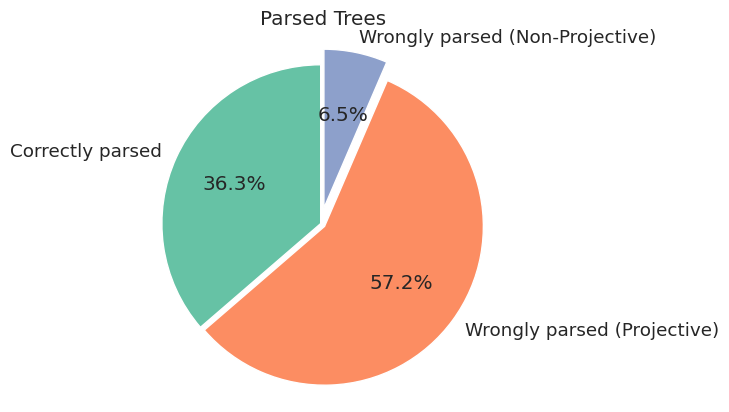

In [ ]:
correct_count = len(test_dataset) - len(wrong_ind)
wrong_projective_count = len(wrong_ind) - wrong_non_proj
wrong_non_projective_count = wrong_non_proj

labels = ['Correctly parsed', 'Wrongly parsed (Projective)', 'Wrongly parsed (Non-Projective)']
sizes = [correct_count, wrong_projective_count, wrong_non_projective_count]
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0, 0.03, 0.1), colors=colors, startangle=90)
ax.set_title('Parsed Trees')
ax.axis('equal')
plt.show()

In [ ]:
gold_moves_flattened = []
for batch in test_dataloader:
    gold_moves_flattened.extend(batch[2])

pred_moves_flattened = []
for predictions in pred_moves_BERT:
    pred_moves_flattened.extend(predictions)

print(len(gold_moves_flattened))
print(len(pred_moves_flattened))

1035
1035


In [ ]:
indices_of_wrong_predictions = []
for i in range(len(test_dataset)):
    if pred_moves_flattened[i] != gold_moves_flattened[i]:
      indices_of_wrong_predictions.append(i)

print(len(indices_of_wrong_predictions))

659


In [ ]:
count_long_sentences = 0
sen_threshold = 20

for idx in indices_of_wrong_predictions:
    if len(gold_moves_flattened[idx]) > sen_threshold:
        count_long_sentences += 1

percentage_long_sentences = (count_long_sentences / len(indices_of_wrong_predictions)) * 100

print(f"{percentage_long_sentences:.2f}% of the errors come from sentences longer than {sen_threshold}.")


81.79% of the errors come from sentences longer than 20.


Sentences typically contain between 15 and 20 words. We've set a threshold of 20 words, marking a sentence as long if it exceeds this limit.

> Using this threshold, we observe that `most of the wrong predictions originate from long sentences`, particularly when attempting to retrieve arcs over longer distances.

Next, let's examine the predictions for non-projective trees:

In [ ]:
print(f"# Non-projective trees:\t\t\t {non_proj}")
print(f"# Wrongly parsed non-projective trees:\t {wrong_non_proj}")

if non_proj == wrong_non_proj:
  print('\nAll the non-projective trees have been parsed wrongly.')

# Non-projective trees:			 67
# Wrongly parsed non-projective trees:	 67

All the non-projective trees have been parsed wrongly.


> We can notice that `all non-projective trees are parsed incorrectly`, as we would expect.

In [ ]:
print("{:.3f}".format(100 * (wrong_non_proj / len(wrong_ind))))

10.167


> The number of wrongly parsed trees is 659. Out of these errors, non-projective trees account for `10.167%`.

Since all non-projective trees are wrongly parsed, excluding them from our analysis would help us arrive at clearer interpretations of the results. Therefore, we proceed with this approach, similarly to what we did for the training dataset.

In [ ]:
test_dataset_non_proj = [sample for sample in test_dataset if is_projective([int(head) for head in sample["head"]])]
test_dataloader_non_proj_with_gold = torch.utils.data.DataLoader(test_dataset_non_proj, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, get_gold_path=True, BERT=True))
(_, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT = test_BERT(model, test_dataloader_non_proj_with_gold)

In [ ]:
gold_moves_flattened = []
for batch in test_dataloader_non_proj_with_gold:
    gold_moves_flattened.extend(batch[2])

# Flatten the list of predicted moves
pred_moves_flattened = [m for sublist in pred_moves_BERT for m in sublist]

print("Total number of gold moves:", len(gold_moves_flattened))
print("Total number of predicted moves:", len(pred_moves_flattened))

Total number of gold moves: 968
Total number of predicted moves: 968


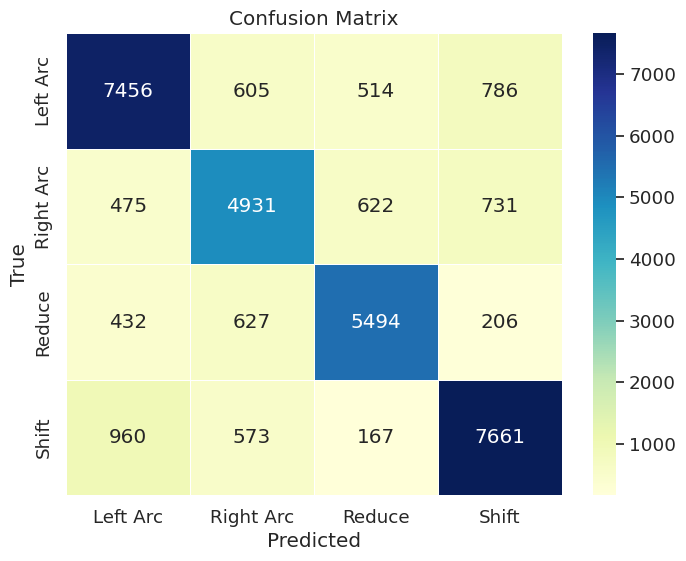

In [ ]:
# Initialize and populate the confusion matrix
class_labels = ['Left Arc', 'Right Arc', 'Reduce', 'Shift']
num_classes = len(class_labels)
conf_matrix = torch.zeros(num_classes, num_classes)

for gold, pred in zip(gold_moves_flattened, pred_moves_flattened):
    min_length = min(len(gold), len(pred))
    conf_matrix += confusion_matrix(gold[:min_length], pred[:min_length], labels=range(num_classes))

conf_matrix = conf_matrix.numpy().astype(int)

# Plotting
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar=True)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
predicted_positives = conf_matrix.sum(axis=0)
actual_positives = conf_matrix.sum(axis=1)

true_positives = conf_matrix.diagonal()
true_negatives = conf_matrix.diagonal().sum() - conf_matrix.diagonal()
false_negatives = actual_positives - true_positives
false_positives = predicted_positives - true_positives

# Per class accuracy
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

# Per class precision and recall
precision = true_positives / predicted_positives
recall = true_positives / actual_positives

# F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
num_classes = conf_matrix.shape[0]
global_f1 = sum(f1_scores) / num_classes

# Prepare table data
table_data = []
for i in range(num_classes):
    table_data.append([f"{class_labels[i]}", accuracy[i], precision[i], recall[i]])

# Prepare table headers
table_headers = ["Class", "Accuracy", "Precision", "Recall"]

# Print table
print(tabulate(table_data, headers=table_headers, tablefmt="fancy_grid", colalign=("center", "center", "center", "center")))

# Print global F1 score
print(f"\nF1-score: {global_f1:.3f}")

╒═══════════╤════════════╤═════════════╤══════════╕
│   Class   │  Accuracy  │  Precision  │  Recall  │
╞═══════════╪════════════╪═════════════╪══════════╡
│ Left Arc  │  0.871324  │  0.799743   │ 0.796496 │
├───────────┼────────────┼─────────────┼──────────┤
│ Right Arc │  0.875476  │  0.732037   │ 0.729546 │
├───────────┼────────────┼─────────────┼──────────┤
│  Reduce   │  0.908645  │  0.808298   │ 0.812842 │
├───────────┼────────────┼─────────────┼──────────┤
│   Shift   │  0.881823  │   0.81639   │ 0.818395 │
╘═══════════╧════════════╧═════════════╧══════════╛

F1-score: 0.789


**Analysis**:

> The confusion matrix summarizes the classification of every transition operator during parsing. From it, as well as from the table with the results, we can observe that the transition with the `highest accuracy is Reduce`, while `Left-Arc has the lowest accuracy`. Overall, Left and Right arc operations are the moves that generate the most confusion. This is due to the Shift operator being often preferred over Left/Right arc operations.


For comparison, here are the results for the entire test dataset, including the non-projective trees:

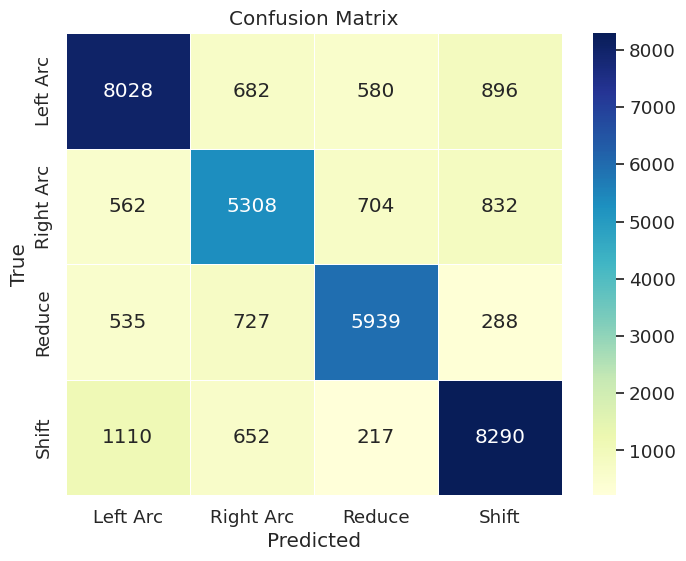

|   Class   |  Accuracy  |  Precision  |  Recall  |
|-----------|------------|-------------|----------|
| Left Arc  |   0.863295 |   0.784367  | 0.788141 |
| Right Arc |   0.868901 |   0.720315  | 0.716716 |
|   Reduce  |   0.900346 |   0.798253  | 0.793030 |
|   Shift   |   0.873416 |   0.804386  | 0.807284 |


F1-score: 0.777

# Tree representation of a correct and wrong prediction

In this section, we randomly take a correct and incorrect prediction in the test set and plot the tree structure. For the wrongly parsed sentence, the words with incorrect heads are also highlighted.

In [ ]:
correct_ind = list(set(range(len(test_dataset))) - set(wrong_ind))
wrong_ix = random.sample(wrong_ind, 1)[0]
correct_ix =  random.sample(correct_ind, 1)[0]

**Correctly parsed sentence representation**

In [ ]:
pred_tokens = test_dataset[correct_ix]["tokens"]
pred_parsing = pred_configs_BERT[correct_ix]
plot_dependency(pred_tokens, pred_parsing)

**Wrongly parsed sentence representation**

In [ ]:
gold_tree = test_dataset[wrong_ix]["head"]
gold_tree = [int(x) for x in gold_tree]
pred_tokens = test_dataset[wrong_ix]["tokens"]
pred_parsing = pred_configs_BERT[wrong_ix]
incorrect_head_idx = [index for index, (item1, item2) in enumerate(zip(gold_tree, pred_parsing)) if item1 != item2]

In [ ]:
print("Tokens with incorrect head:\n"  )

for i in incorrect_head_idx:
  pred_head_ix = pred_parsing[i]
  correct_head_ix = gold_tree[i]
  print(pred_tokens[i], " (ix: ", i, ")  -  Pred head: ",  pred_tokens[pred_head_ix], " (ix:", pred_head_ix, ")   -  Correct head: ", pred_tokens[gold_tree[i]], "(ix:", correct_head_ix,")")

plot_dependency(pred_tokens, pred_parsing)

Tokens with incorrect head:

,  (ix:  5 )  -  Pred head:  eyes  (ix: 7 )   -  Correct head:  wider (ix: 8 )
eyes  (ix:  7 )  -  Pred head:  shook  (ix: 2 )   -  Correct head:  wider (ix: 8 )


**Wrongly parsed sentence gold tree**

In [ ]:
plot_dependency(pred_tokens, gold_tree)

# Discussion

In this section, we will **compare the performance of our two models**: Bi-LSTM, used as a baseline, and the BERT-based model. First, we will describe our approach in order to find the model with the best UAS score on the test set for each architecture. Then, we proceed with the comparison of both architectures. As we collected the metrics of our experiments using the Weight and Biases platform, we'll present the reports that gathered their results.

Additionally, we will compare our implementations with the **current state-of-the-art results** on the chosen dataset.

## Hyperparameter tuning

### Bi-LSTM

In [ ]:
HTML('<iframe src="https://wandb.ai/unipd-ds/NLP_ArcEager/reports/Hyperparameter-tuning-I---Vmlldzo2Nzg5NDg2" frameborder="0" width="2000" height="1600"></iframe>')

### BERT-based model

In [ ]:
HTML('<iframe src="https://wandb.ai/unipd-ds/NLP_ArcEager/reports/-Hyperparameter-tuning-II---Vmlldzo2NzkwMTgz" frameborder="0" width="2000" height="1600"></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Models comparison

In [ ]:
HTML('<iframe src="https://wandb.ai/unipd-ds/NLP_ArcEager/reports/Comparison-between-BiLSTM-and-BERT--Vmlldzo2Nzg5ODI0" frameborder="0" width="2000" height="1600"></iframe>')

# State-of-the-Art

For the chosen UD treebank (en-LinES) we collected the latest information on the improvements of the evaluation metric UAS (Unlabeled Attachment Score) for dependency parsing:





| Model  | UAS | Source                                               |
|--------|-------|------------------------------------------------------|
| UDPipe 2 | 91.32 | [Source 1](https://ufal.mff.cuni.cz/udpipe/2/models) |
| Udify  | 89.56 | [Source 2](https://aclanthology.org/2021.sigtyp-1.5.pdf) |
| Stanza 1.5 | 88.67 | [Source 3](https://stanfordnlp.github.io/stanza/performance.html) |
| UDPipe | 84.79 | [Source 4](https://aclanthology.org/2021.sigtyp-1.5.pdf) |




Related to the first and third-ranked tools, UDPipe 2 and Stanza 1.5, the evaluation metric was generated using the Universal Dependencies version 2.12 (released in the latter half of 2023). These values were generated using the CoNLL 2018 UD shared task official evaluation script. This data was obtained from these toolkits official website.

Additionally, the UAS scores for Udify and UDPipe were obtained from a paper published in the 2021 SIGTYP workshop: "[Improving the performance of UDify with Linguistic Typology Knowledge](https://aclanthology.org/2021.sigtyp-1.5/)"